# NTSB Modeling 1 - Text Embeddings

## NOT ADDING FILLER

1. Create data strings
2. Embed text data

## Create data strings

In [1]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [2]:
#!pip install transformers

In [87]:
import pandas as pd
import numpy as np
import csv
import re
import torch
import random
import time
import datetime
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoModelForSequenceClassification
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [4]:
data = pd.read_csv('labeled_clean_ntsb.csv')

C:\Users\htwal\AppData\Local\Temp\ipykernel_25552\421915254.py:1: DtypeWarning: Columns (3,17,18,23,44,45,78,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('labeled_clean_ntsb.csv')


In [5]:
def make_strings(month, time, state, airport, conditions, alt, wx, light, makemodel, num, plan, airspace, hrs):
    return f'Flight scheduled in the month of {month} at time {time} in state {state} from {airport} airport the flight conditions were {conditions} the flight altitude was {alt}\
    the weather and visibility was {wx} lighting conditions were {light} the flight was conducted in a {makemodel} with a crew of {num} the flight plan filed was {plan}\
    and the flight planned to fly in {airspace} airspace flight crew recent hours were {hrs}' 

In [6]:
time1 = pd.read_csv('flight_time_pt.csv')
time2 = pd.read_csv('flight_time_pre.csv')

In [7]:
time = pd.concat([time1, time2])
time = time.drop(['Aircraft_Key', 'crew_no'], axis=1)

In [8]:
time.columns

Index(['ev_id', 'flight_type', 'flight_craft', 'flight_hours', 'lchg_date',
       'lchg_userid'],
      dtype='object')

In [9]:
time['ev_id'] = time['ev_id'].str.lower()

In [10]:
# create a pivot table:
time_pt = pd.pivot_table(time, values='flight_hours', index=['ev_id'], columns=['flight_craft'])

In [11]:
time_pt.shape

(78293, 12)

In [12]:
data = data.fillna('unknown')

In [13]:
# merge with main data set
data_set = data.merge(time_pt, left_on='aircraft_ev_id', right_on='ev_id')

In [14]:
# Create training dataset:
cols = ['Unnamed: 0', 'aircraft_ev_id', 'far_part', 'damage', 'phase_flt_spec', 'ntsb_no', 
        'ev_year', 'ev_type', 'apt_dist', 'apt_dir', 'ev_highest_injury', 'inj_tot_t', 'secondary_eng_mfgr',
        'crew_inj_level', 'inj_target', 'damage_target', 'hp_or_lbs', 'carb_fuel_injection', 'wx_src_iic', 'wx_obs_fac_id', 'wx_obs_elev', 'wx_obs_dir', 'wx_obs_dist',
        'gust_ind', 'wind_vel_ind', 'crew_category', 'pilot_flying', 'med_certf', 'INC', 'LTA', 'GLDR',
        'REL']
data_set = data_set.drop(cols, axis=1)

In [15]:
# force all to str
data_set = data_set.applymap(str)

In [16]:
data_set = data_set.applymap(lambda x: x.replace('nan', 'unknown'))
data_set = data_set.applymap(lambda x: re.sub(r'\bn\b', 'no', x))
data_set = data_set.applymap(lambda x: re.sub(r'\by\b', 'yes', x))

In [17]:
data_set = data_set.applymap(lambda x: x.strip())

In [18]:
data_set['concat'] = data_set.apply(lambda x: ' '.join(map(str, x)), axis=1)

In [19]:
training = data_set[['concat', 'target']]
training['target'] = training['target'].str.replace(r'target ', '').astype(int).apply(lambda x: x-1.0)

C:\Users\htwal\AppData\Local\Temp\ipykernel_25552\3979246843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['target'] = training['target'].str.replace(r'target ', '').astype(int).apply(lambda x: x-1.0)


In [20]:
print(len(training['concat']))

46052


In [21]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46052 entries, 0 to 46051
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   concat  46052 non-null  object 
 1   target  46052 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


### Create a rebalanced dataset

In [22]:
data_strings = [[x] for x in list(training['concat'])]
data_target = list(training['target'])

In [23]:
# undersample 3
rus = RandomUnderSampler(sampling_strategy={2:11968}, random_state=25)
X_res, y_res = rus.fit_resample(data_strings, data_target)
print('Resampled dataset shape %s' % Counter(y_res))

# oversample 1, 2
ros = RandomOverSampler(random_state=33)
X_bal, y_bal = ros.fit_resample(X_res, y_res)
print('Resampled dataset shape %s' % Counter(y_bal))

Resampled dataset shape Counter({2.0: 11968, 3.0: 11968, 1.0: 589, 0.0: 92})
Resampled dataset shape Counter({0.0: 11968, 1.0: 11968, 2.0: 11968, 3.0: 11968})


In [24]:
X_bal = [x[0] for x in X_bal]

In [25]:
label_df = pd.DataFrame(y_bal)


In [26]:
label_enc = pd.get_dummies(label_df, columns=[0])

In [27]:
print(len(X_bal))
print(len(y_bal))

47872
47872


## GPT & Transformer Setup

In [28]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [29]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [30]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    problem_type="multi_label_classification",
    num_labels = 4,
    ignore_mismatched_sizes=True
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Training Parameters

In [31]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 8

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
learning_rate = 1e-5

# Number of training epochs. 
epochs = 4

In [32]:
max_len = 0

# For every sentence...
for x in X_bal:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(x, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  221


### Tokenize and Encode

In [33]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Encoding all records in the dataset...')

# For every sentence...
for x in X_bal:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        x,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_2 = torch.cat(input_ids, dim=0)
attention_masks_2 = torch.cat(attention_masks, dim=0)


print('DONE.')

Encoding all records in the dataset...
DONE.


In [34]:
# labels encoded, and converted to float and into tensor
label = label_enc.values.tolist()
label = [list(map(float, sublist)) for sublist in label]

In [35]:
labels = torch.tensor(label)

### Training

In [39]:
# train / test splits
# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(X_bal))
val_size = int(0.1 * len(X_bal))
test_size = len(X_bal) - (train_size + val_size)

# Sanity check the sizes.
assert((train_size + val_size + test_size) == len(X_bal))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(X_bal))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using, 
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 38,297
Validation size: 4,787
      Test size: 4,788


In [40]:
test = labels[train_idx]
print(test.shape)

torch.Size([38297, 4])


In [41]:
# Split the samples, and create TensorDatasets for each split. 
train_dataset = TensorDataset(input_ids_2[train_idx], attention_masks_2[train_idx], labels[train_idx])
val_dataset = TensorDataset(input_ids_2[val_idx], attention_masks_2[val_idx], labels[val_idx])
test_dataset = TensorDataset(input_ids_2[test_idx], attention_masks_2[test_idx], labels[test_idx])

In [42]:
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [43]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )

C:\Users\htwal\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [44]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples!)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [60]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [47]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
torch.cuda.empty_cache()
# Set the seed value all over the place to make this reproducible.
seed_val = 33

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
         
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...

Running Validation...
Total_eval_loss
0.0007805281202308834
logits
[[ 7.3971534 -6.971365  -6.9803777 -7.178803 ]
 [-7.168215   7.3107553 -6.999471  -7.1435537]
 [-7.1126695 -7.074663   7.3667917 -7.2951226]
 [ 7.425427  -6.918043  -7.0197325 -7.164004 ]
 [-7.192927   7.286718  -6.9858227 -7.1609445]
 [-7.123349  -7.0677958  7.3703294 -7.286436 ]
 [-7.1801867 -7.0681996 -7.115938   7.4327054]
 [ 7.4090834 -6.9543967 -6.9798126 -7.1840973]]
label_ids
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]
pred_flat
[0 1 2 0 1 2 3 0]
labels_flat
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 0.]
Total_eval_loss
0.0015611120616085827
logits
[[ 7.3897014 -6.9488816 -7.000618  -7.18435  ]
 [ 7.3953342 -6.9597673 -6.990203  -7.182978 ]
 [-7.1679153  7.3003917 -7.0134373 -7.142638 ]
 [-7.1099734 -7.0597606  7.387591  -7.2916613]
 [-7.2072

C:\Users\htwal\AppData\Local\Temp\ipykernel_25552\574929761.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


logits
[[-7.0970864 -7.036963   7.3894725 -7.3273454]
 [-7.21524   -7.0209117 -7.1245427  7.443084 ]
 [-7.209376  -7.0438437 -7.1276116  7.4183393]
 [-7.1546297  7.2997336 -7.0353947 -7.129207 ]
 [-7.201057  -7.0343537 -7.139823   7.422179 ]
 [ 7.420051  -6.89346   -7.0367184 -7.172397 ]
 [-7.148983   7.3265567 -7.011236  -7.130141 ]
 [ 7.4068313 -6.952349  -6.9896293 -7.1789503]]
label_ids
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
pred_flat
[2 3 3 1 3 0 1 0]
labels_flat
[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0.]
Total_eval_loss
0.003117336891591549
logits
[[-7.192836  -7.0408053 -7.134985   7.4301715]
 [-7.208655  -7.0347657 -7.1292443  7.4251127]
 [-7.15616    7.322267  -6.9894104 -7.1528473]
 [-7.1981874 -7.016613  -7.1194115  7.4662232]
 [ 7.4065866 -6.9423285 -6.956433  -7.2197356]
 [-7.1371255  7.329142  -7.0309734 -7.120307 ]
 [-7.1465793  7.3105

In [48]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss
epoch,,
1,0.031461,0.000774
2,0.000459,0.000107
3,0.000057,0.000020
4,0.000014,0.000008


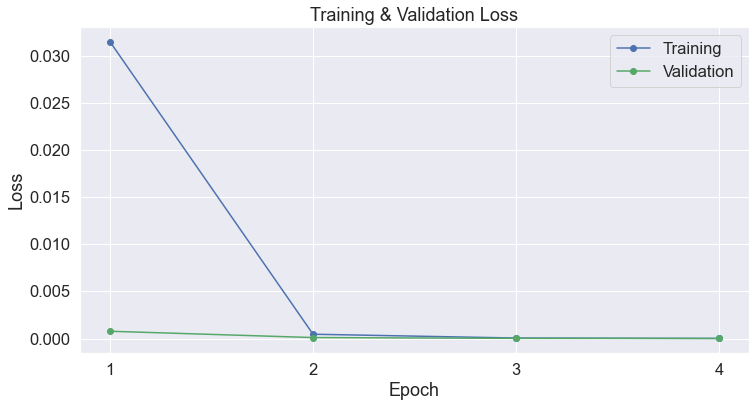

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [52]:
plt.savefig('BERT2.jpg')

<Figure size 864x432 with 0 Axes>

### TESTING

In [61]:
# Create a DataLoader to batch our test samples for us. We'll use a sequential
# sampler this time--don't need this to be random!
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,788 test sentences...
    DONE.


In [70]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
print(flat_predictions)
# Combine tflat_predictionshe correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)
flat_true_predictions = np.argmax(flat_true_labels, axis=1).flatten()
print(flat_true_predictions)

[0 2 0 ... 3 2 2]
[0 2 0 ... 3 2 2]


In [97]:
# scores
accuracy = accuracy_score(flat_predictions, flat_true_predictions)
f1 = f1_score(flat_true_predictions, flat_predictions, average='weighted')
precision = precision_score(flat_true_predictions, flat_predictions, average='weighted')
recall = recall_score(flat_true_predictions, flat_predictions, average='weighted')
print(accuracy)
print(f1)
print(precision)
print(recall)

1.0
1.0
1.0
1.0
